In [1]:
! pip install git+https://github.com/deepmind/pycolab.git

  Cloning https://github.com/deepmind/pycolab.git to /tmp/pip-7fIIqq-build
  Running setup.py install for pycolab ... - done


## Maze generating using Pycolab

Pycolab has been installed using above code. It provides a simpler way to build maze game environment. The maze arts were defined in $GAME\_ART$ variable as can be seen below. Then a game object can be generated by simply using $ascii\_art$ library. The rules of the maze game can be defined using $sprites$ class, including game art symbol mapping, action mapping, rewards, and terminate state(s). 

A new maze game can be made by calling $make\_game()$ method with desired maze art index.


In [0]:
import pycolab
from pycolab import ascii_art
from pycolab import human_ui
from pycolab.prefab_parts import sprites as prefab_sprites


# Origin (0,0) is at top-left corner
GAME_ART = [['.........',
             '.........',
             '.........',
             '########.',
             '.........',
             '...P.....'],

            ['.........',
             '.........',
             '.........',
             '.########',
             '.........',
             '...P.....'],
            
            ['.........',
             '.........',
             '.........',
             '.#######.',
             '.........',
             '...P.....']
            ]

def make_game(mazeIndex=0):
  """Builds and returns a cliff-walk game."""
  return ascii_art.ascii_art_to_game(
      GAME_ART[mazeIndex], what_lies_beneath='.',
      sprites={'P': PlayerSprite})


class PlayerSprite(prefab_sprites.MazeWalker):
  
  def __init__(self, corner, position, character):
    """Inform superclass that we can go anywhere, but not off the board."""
    super(PlayerSprite, self).__init__(
        corner, position, character, impassable='#', confined_to_board=True)

  def update(self, actions, board, layers, backdrop, things, the_plot):
    del layers, backdrop, things   # Unused.

    # Apply motion commands.
    if actions == 0:    # walk upward?
      self._north(board, the_plot)
    elif actions == 1:  # walk downward?
      self._south(board, the_plot)
    elif actions == 2:  # walk leftward?
      self._west(board, the_plot)
    elif actions == 3:  # walk rightward?
      self._east(board, the_plot)
    else:
      # All other actions are ignored. Although humans using the CursesUi can
      # issue action 4 (no-op), agents should only have access to actions 0-3.
      # Otherwise staying put is going to look like a terrific strategy.
      return

    # See if the game is over.
    if self.position[0] == 0 and self.position[1] == 8:
        the_plot.add_reward(1.0)
        the_plot.terminate_episode()
    else:
        the_plot.add_reward(0.0)


## DynaQ 

DynaQ class implemented DynaQ algorithm following the testbook. The $run()$ method plays the game for one episode when it gets called. The environment $model$ and action model $Q$ can be trained from several episodes by calling $run()$ method multiple times. It also provides the option of maze art changing at certain steps. The utilization can be found in the test experiments below. 

In [0]:
import numpy as np
# import blockingMaze

class DynaQ:

    def __init__(self,mazeIndex=0):
        # step size
        self.alpha = 0.7 #0.1
        # discount
        self.gamma = 0.95
        # greed algorithm factor
        self.epslon = 0.1
        # planning steps
        self.n = 5

        self.mazeIndex = mazeIndex
        self.mazeIndex2 = 1
        self.changeMaze = False
        self.changeStep = 1000
        self.game = make_game(self.mazeIndex) # blockingMaze.make_game(self.mazeIndex)
        self.episode = 1
        # get initial state of game
        obs, r, gamma = self.game.its_showtime()
        self.s = get_state(obs)

        # cumulative reward, steps
        self.reward = 0
        self.steps = 0
        self.results = [[self.reward, self.steps]]
        self.max_step = 3000

        self.actions = [0, 1, 2, 3]

        # initial Q(s,a) and Model(s,a)
        self.Q = np.zeros((self.game.rows, self.game.cols, len(self.actions)))
        self.model = Model()
        
        self.verbose = False

    def run(self):

        while not self.game.game_over:      
            # break when reach max steps
            if dynaq.steps > self.max_step:
              self.results.append([self.reward, self.steps])
              break 
            # switch maze when step reach certain value
            if self.changeMaze and self.steps == self.changeStep:
                print('Switch at ', self.steps)
                self.mazeIndex = self.mazeIndex2
                print(self.mazeIndex2)
                
            # current state
            s = self.s
            # get action from epslon-greedy
            a = np.random.choice(e_greedy(self.epslon, s, self.Q, self.actions), 1)[0]

            # tell game agent to execute action a
            obs, r, gamma = self.game.play(a)
            s_next = get_state(obs)

            self.steps += 1
            self.reward += r

            # update Q
            self.Q[s[0]][s[1]][a] = self.Q[s[0]][s[1]][a] + self.alpha * (r + self.gamma * max(self.Q[s_next[0]][s_next[1]]) \
                                                                          - self.Q[s[0]][s[1]][a])
            # update model
            self.model.insert(s, a, s_next, r)
            # update Q using simulated experience from model
            for _ in range(self.n):
                ss, sa, ss_next, sr = self.model.get_simulate_experience()
                self.Q[ss[0]][ss[1]][sa] = self.Q[ss[0]][ss[1]][sa] + self.alpha * (sr + self.gamma * max(self.Q[ss_next[0]][ss_next[1]])\
                                                                              - self.Q[ss[0]][ss[1]][sa])
            # current state is next state
            self.s = s_next

        if self.game.game_over:
            if self.verbose: 
              print('Episode {} over, reward: {}'.format(self.episode, self.reward))
            self.results.append([self.reward, self.steps])
            self.game = make_game(self.mazeIndex)#blockingMaze.make_game(self.mazeIndex)
            self.episode += 1
            obs, r, gamma = self.game.its_showtime()
            self.s = get_state(obs)


class Model:

    def __init__(self):
        # double dict: Model(s,a) --> s', R
        self.model = dict()

        self.use_seed = False
        self.randomseed = 42
        # apply random seed
        if self.use_seed:
            np.random.seed(self.randomseed)

    def insert(self, s, a, s_next, r):
        # state must be tuple
        if s not in self.model.keys():
            self.model[s] = dict()
        #print(s, a, self.model)
        self.model[s][a] = [s_next, r]

    def get_simulate_experience(self):
        # random sample s and a
        s_index = np.random.choice(len(self.model.keys()), 1)[0]
        s = list(self.model.keys())[s_index]
        a = np.random.choice(list(self.model[s].keys()), 1)[0]
        s_next, r = self.model[s][a]
        return s, a, s_next, r


def e_greedy(epslon, s, Q, actions):
    # explore
    if np.random.binomial(1, epslon) == 1:
        return np.random.choice(actions, 1)
    else:
        # exploit
        max_value = max(Q[s[0]][s[1]])
        return [a for a in actions if Q[s[0]][s[1]][a] == max_value]


def get_state(obs):
    allstates = np.array(obs.layers['P'], dtype=np.float)
    s = np.unravel_index(np.argmax(allstates, axis=None), allstates.shape)
    return s

## Test

### Test 1: how does planning step influence convergence 

Four different planning step were tested. As can be seen from the graph, DynaQ with a larger planning step finds the optimal policy faster (within fewer episodes). This is consistent with the results from textbook. 

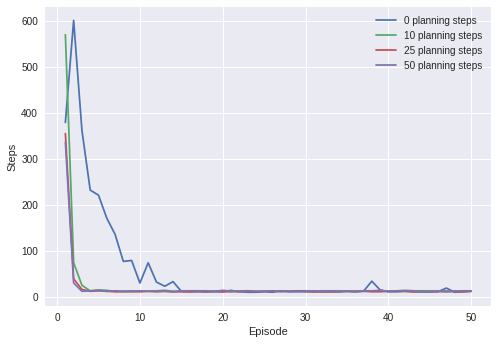

In [24]:
import matplotlib.pyplot as plot

n_eps = 50
n_round = 10

for n in [0, 10, 25, 50]:
  allstep = []
  for round in range(n_round): 
    dynaq = DynaQ()
    dynaq.n = n
    dynaq.max_step = 10000
    for episode in range(n_eps):
        dynaq.run()

    reward = [x[0] for x in dynaq.results]
    steps = [x[1] for x in dynaq.results]
    step_per_esp = [steps[i+1]-steps[i] for i in range(len(steps)-1)]
    allstep.append(step_per_esp) 
 
  avgstep = [sum(x)/n_round for x in list(zip(*allstep))]
  plot.plot(reward[1:], avgstep, label='{} planning steps'.format(n))

plot.xlabel('Episode')
plot.ylabel('Steps')
plot.legend()
plot.show()

### Test 2: Blocking maze and Shortcut maze
**Blocking maze** experiment was setup using parameters as shown in the code below. The wall area in the maze was changed when cumulative steps reach 1000. Corresponding maze arts can be found in $GAME\_ART$ list varible (the first and second one). After the maze was changed, DynaQ took around 800 steps to recover from the wrong model. This result is also consistent with the results from textbook. 

('Switch at ', 1000)
1


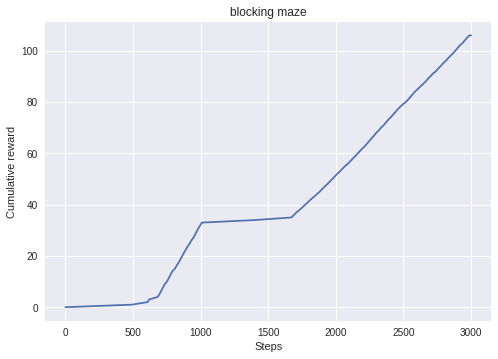

In [23]:
# maze index map to GAME_ART
mazes = {'blocking':1, 'shortcut':2}

dynaq = DynaQ()

# set parameters
dynaq.n = 5
dynaq.alpha = 0.7
dynaq.verbose = False #True 
dynaq.changeMaze = True 
dynaq.mazeIndex2 = mazes['blocking']
dynaq.changeStep = 1000

n_eps = 300
for _ in range(n_eps):
  dynaq.run()
  if dynaq.steps > dynaq.max_step:
    break 

reward = [x[0] for x in dynaq.results]
steps = [x[1] for x in dynaq.results]

plot.plot(steps, reward)
plot.title('blocking maze')
plot.xlabel('Steps')
plot.ylabel('Cumulative reward')
plot.legend()
plot.show()

**Shortcut maze** was setup as following. Different from blocking maze experiment, the maze art changes when the number of steps reaches 3000. Corresponding maze arts can be found in $GAME\_ART$ list (the second and third one). DynaQ is not able to observe the shortcut because it is stuck in the suboptimal policy of the first maze art. 

Switch at  3000
2


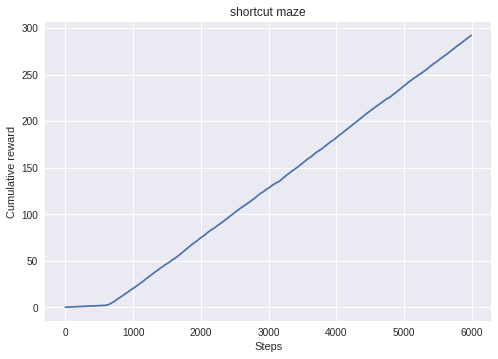

In [127]:
dynaq = DynaQ(mazeIndex=1)

# set parameters
dynaq.n = 5
dynaq.alpha = 0.7
dynaq.verbose = False #True 
dynaq.changeMaze = True 
dynaq.mazeIndex2 = mazes['shortcut']
dynaq.changeStep = 3000
dynaq.max_step = 6000

n_eps = 500
for _ in range(n_eps):
  dynaq.run()
  if dynaq.steps > dynaq.max_step:
    break 

reward = [x[0] for x in dynaq.results]
steps = [x[1] for x in dynaq.results]

plot.plot(steps, reward)
plot.title('shortcut maze')
plot.xlabel('Steps')
plot.ylabel('Cumulative reward')
plot.legend()
plot.show()

# Dyna-Q and Experience Replay

Dyna-Q uses knowledge about past experiences to build an action model which it then uses for planning. Dyna architechture records an experience only once; this can be contrasted with the notion of experience replay, which emphasizes the reuse of past experience potentially multiple times. Experience replay allows the agent to learn quicker by reducing the number of actual samples from the environment: past experiences are remembered and repeatedly presented to the learning algorithm as if they were new. Granted, the reuse of past experiences must be done while accounting for the bias of potentially overly bad or overly good past experiences to minimize propagation of inaccurate credit/blame assignment. In this way, an action model that is learned by a strategy similar to Dyna can be used for further improvement via experience replay. The two approaches can be combined to  yield superior results.

The main advantage of experience replay is the faster convergence towards optimality (in the number of environment samples). The faster the agent learns, the less penalty (or the higher the amount of reward) it is likely to incur in a given environment. Thus, experience replay is a speed up technique applicable for temporal learning. The Dyna architechture acquires experiences through trial-and-error, but utilizes these only once; experience replay provides a mechanism to effectively and intelligently reuse useful past experiences to hasten learning.